В этому ноутбуке рассматривается модель с encoder-decoder, представляющими собой самописные трансформеры (включающие механизм attention и self-attention) 

In [38]:

! pip  install subword-nmt
! pip install nltk
! pip install torchtext

In [39]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
File ‘data.txt’ already there; not retrieving.



In [40]:
if not os.path.exists('./utils.py'):
    print("utils file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/utils.py -nc

if not os.path.exists('./my_network.py'):
    print("network file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/my_network.py -nc

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [42]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [43]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)


TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [44]:
print(dataset)

In [45]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.83, 0.15, 0.02], random_state=random.seed(23))

In [46]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 41500
Number of validation examples: 1000
Number of testing examples: 7500


In [47]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [48]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9522
Unique tokens in target (en) vocabulary: 6852


Here are tokens from original (RU) corpus:

In [49]:
os.chdir("/content/drive/MyDrive/MADE/semester2/NLP/lab2/")

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
%load_ext autoreload
%autoreload 2

os.chdir("/content/drive/MyDrive/MADE/semester2/NLP/lab2/")
from  transformer_network import *
from pipeline_func import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 2
DEC_LAYERS = 2
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [53]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [54]:
 def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

 model.apply(initialize_weights)

# def init_weights(m):
#     for name, param in m.named_parameters():
#         if 'weight' in name:
#             nn.init.normal_(param.data, mean=0, std=0.03)
#         else:
#             nn.init.constant_(param.data, 0)
            
# model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(9522, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
     

In [55]:
!nvidia-smi

Sun Jun  6 15:48:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |   7939MiB / 16280MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [69]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#print(f'The model has {count_parameters(model):,} trainable parameters')

LEARNING_RATE = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

#optimizer = optim.Adam(model.parameters())

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [57]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [58]:
#!pip install -U torchtext
#!npm list
print (torchtext.__version__)

0.9.1


__Let's take a look at our network quality__:

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [59]:
train_history = []
valid_history = []

In [60]:
N_EPOCHS = 10

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [61]:
#LEARNING_RATE = 0.00001
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, )
#optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

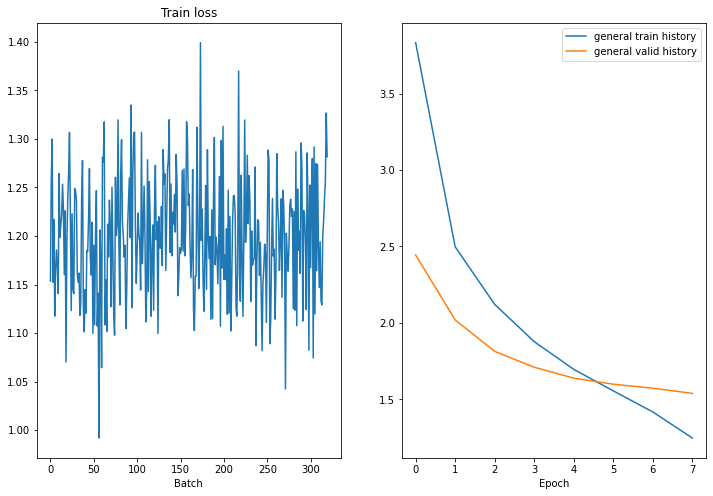

Epoch: 01 | Time: 0m 30s
	Train Loss: 1.198 | Train PPL:   3.314
	 Val. Loss: 1.536 |  Val. PPL:   4.646


In [72]:
N_EPOCHS = 1
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    #train_loss = train(model, train_iterator, optimizer, criterion, scheduler, CLIP, train_history, valid_history)
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut6-model.pt')
        torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/model_transformers/", f"lab2_transformer_best{best_valid_loss}.pt")
           )       
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [63]:
model1 = model

In [73]:
#model_state  = torch.load("/content/drive/MyDrive/MADE/semester2/NLP/lab2/model_transformers/lab2_transformer_best1.561556600034237.pt")
#model_state  = torch.load("/content/drive/MyDrive/MADE/semester2/NLP/lab2/lab2_transformer_best.pt")
#model1 = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
#model.load_state_dict(model_state['model_state_dict'])

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.518 | Test PPL:   4.564 |


In [71]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/model_transformers", f"lab2_transformer_newscore_1.pt")
           )     

In [74]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation_2
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
(original_text, generated_text) = generate_translation(model, test_iterator, TRG.vocab)

59it [00:00, 62.31it/s]


In [82]:
for i, (ot, gt) in enumerate(zip(original_text, generated_text)):
   if (i > 2700) and (i < 2800):
      print(" ".join(ot))
      print(" ".join(gt))
      print("\n")
   

the kitchen is equipped with a fridge , microwave , oven and a dining area .
the kitchen is equipped with a fridge , microwave and oven and a microwave area .


this resort is on the east coast of spain , in the province of .
this resort is located the eastern of of in in the of .


they also have a private bathroom with a hairdryer and a balcony .
each also have a balcony balcony with a hairdryer and a hairdryer .


breakfast includes sweet croissants and pastries with hot drinks .
breakfast includes sweet croissants and hot . hot drinks .


you can go fishing with free fishing provided by .
free can enjoy for for for free fishing . . . the .


offering free bikes , riad marrakech is located in marrakech .
guests free bicycles , the also , available in ,


a number of restaurants serving a range of local and international cuisines can be found within 4 km .
local variety of local and local variety of local and international cuisine are be found within 4 km .


breakfast , lunch , and 

In [78]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        #print(src)
        #print(trg)
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
     
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        #print(pred_trg)
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        

    return bleu_score(pred_trgs, trgs)

In [79]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 29.02


In [ ]:
print(test_data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Получили следующие показатели для модели**
```
  Epoch: 01 | Time: 0m 30s
	Train Loss: 1.198 | Train PPL:  3.314
	Val. Loss:  1.536 |  Val. PPL:  4.646


  Test BLEU score = 29.02
```
**Удачные переводы: (все так же в лучшем случае - дословный перевод, никаких вариаций )**

the fully equipped kitchen comes with a fridge and a microwave .  
there fully equipped kitchen includes with a refrigerator and microwave microwave .

beach is around 12 km from corfu port .  
beach is about 12 km from corfu town .

all rooms are equipped with a flat - screen tv with satellite channels .  
all rooms are equipped with a flat - screen tv with satellite channels .

**Неудачные переводы:**  
at vila hotel you will find a 24 - hour front desk and a garden . the property offers free parking .  
vila vila vila will find a 24 - hour front desk and free free . free property offers free parking .




**Cкорость обучения модели:**  
(число эпох * число обработанных батчей за одну эпоху * размер батча):
10 * 41000 (~162 батчей по 256) 

**Время:**

30 сек на эпоху. Трансформер оказался одним из самых быстрых моделей по скорости обучения.

**Оцените степень переобучения модели**  
На трейне loss ниже, чем на валидейшене. Переобучение есть, но берем то значение весов, когда loss на валидейшене минимальное, до начала роста. 

Начальное распределение весов очень важно. В этом примере взяла в качестве начального распределения весов xavier_uniform_


Для сходимости использовали оптимизатор Adam с шагом 0.0005. Этот оптимизатор лучше всего работает с текстами. Sheduler не использовала. Но в конце, когда сеть начала переобучаться пришлось немного уменьшить шаг, и валидейшн чуть-чуть тоже упал, перед тем, как начать расти.


